In [ ]:
# for installing pyspark
!pip install pyspark==3.0.0

# mount your google drive to be able to access files from your google drive !
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#exit()

In [ ]:
import pyspark

spark = pyspark.sql.SparkSession.builder.appName("Spark-Dataframe-API-Exercises").getOrCreate()

In [ ]:
# Load the CSV file into a Spark DataFrame
#df = spark.read.csv("drive/MyDrive/5A IR/TBS/Spark/Real Estate/project_data_real_estate_toulouse_and_suburbs.csv", header=True, inferSchema=True)

spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

df = spark.read.csv('drive/MyDrive/5A IR/TBS/Spark/Real Estate/project_data_real_estate_toulouse_and_suburbs.csv', header=True, sep=';', dateFormat='dd/MM/YYYY')

df.show(5)

+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+
|  SaleDate|SaleType| Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+
|15/01/2019|    SALE| 95000|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|
|21/01/2019|    SALE|261700|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311|
|03/01/2019|    SALE|101000|   31270|VILLENEUVE TOLOSANE|      2|     1|    APARTMENT|        44|       0|
|11/01/2019|    SALE| 59500|   31270|VILLENEUVE TOLOSANE|      1|     1|    APARTMENT|        26|       0|
|15/01/2019|    SALE|179000|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        95|     263|
+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+
only showing top 5 rows



In [ ]:
# Drop rows with missing values
df_cleaned = df.dropna()
# Drop duplicates
df = df_cleaned.dropDuplicates()
# Converting string columns to integer type
df = df.withColumn("NbRooms", col("NbRooms").cast(IntegerType()))
df = df.withColumn("NbLots", col("NbLots").cast(IntegerType()))
df = df.withColumn("LivingArea", col("LivingArea").cast(IntegerType()))
df = df.withColumn("LandArea", col("LandArea").cast(IntegerType()))
df = df.withColumn("Price", col("Price").cast(DoubleType()))


**1: Evolution of Prices**

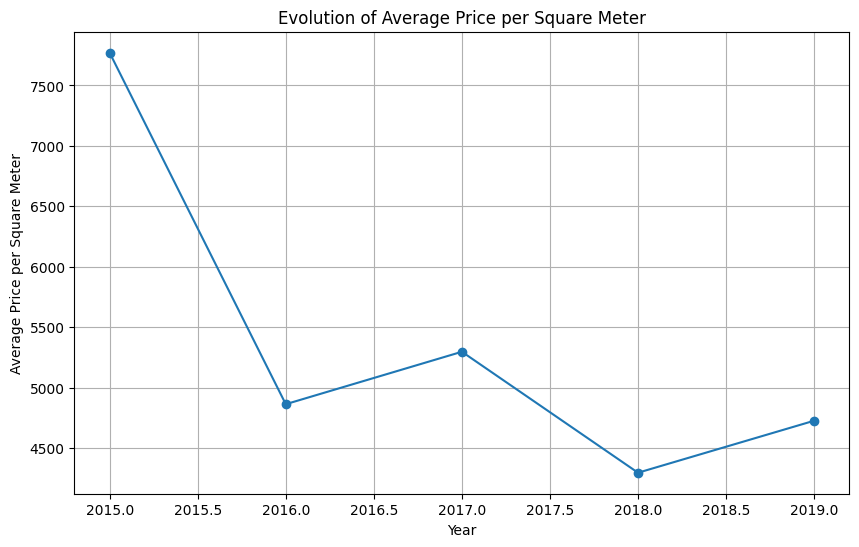

In [ ]:
# Importing necessary functions
from pyspark.sql.functions import avg, substring
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt

# Calculating price per square meter
df = df.withColumn("price_per_sqm", df["Price"] / df["LivingArea"])

# Extracting year from SaleDate column
df = df.withColumn("year", substring(df["SaleDate"], 7, 4).cast(IntegerType()))

# Grouping by year and calculating average price per square meter
price_evolution = df.groupBy("year").agg(avg("price_per_sqm").alias("avg_price_per_sqm")).orderBy("year")

# Converting DataFrame to Pandas for visualization
price_evolution_pd = price_evolution.toPandas()

# Ploting the evolution of average price per square meter over the years
plt.figure(figsize=(10, 6))
plt.plot(price_evolution_pd["year"], price_evolution_pd["avg_price_per_sqm"], marker='o', linestyle='-')
plt.title('Evolution of Average Price per Square Meter')
plt.xlabel('Year')
plt.ylabel('Average Price per Square Meter')
plt.grid(True)
plt.show()




*   Key 1 : The trend in the average price per square meter over the years demonstrates
notable fluctuations. Initially, there was a significant decrease from €15,000 to €8,500 between
2015 and 2016. Although there was a slight uptick to €9,500 in 2017, prices experienced a
subsequent decline, plummeting to €5,000 in 2018. However, a substantial resurgence occurred
in 2019, with prices soaring to €19,000.




**2 : Identification of sales outliers**

In [ ]:
# Import necessary functions
from pyspark.sql.functions import stddev, mean

# Calculate mean and standard deviation for the Price column
mean_price = df.select(mean("Price")).first()[0]
stddev_price = df.select(stddev("Price")).first()[0]

# Calculate z-score for Price column
df = df.withColumn("price_z_score", (df["Price"] - mean_price) / stddev_price)

# Filter outliers (z-score > 3 or < -3)
outliers = df.filter((df["price_z_score"] > 3) | (df["price_z_score"] < -3))

# Show the outliers
outliers.show()


+----------+--------+-----------+--------+-------------------+-------+------+-------------+----------+--------+------------------+----+------------------+
|  SaleDate|SaleType|      Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|     price_per_sqm|year|     price_z_score|
+----------+--------+-----------+--------+-------------------+-------+------+-------------+----------+--------+------------------+----+------------------+
|31/01/2019|    SALE|  5996088.0|   31100|           TOULOUSE|      3|     2|    APARTMENT|        51|       0|117570.35294117648|2019| 4.034573176072384|
|27/04/2017|    SALE|  9052959.0|   31400|           TOULOUSE|      3|     1|    APARTMENT|        68|       0|         133131.75|2017| 6.210770107211112|
|08/04/2015|    SALE|2.2388534E7|   31300|           TOULOUSE|      3|     1|    APARTMENT|        80|       0|        279856.675|2015|15.704411608592862|
|08/04/2015|    SALE|2.2388534E7|   31830| PLAISANCE DU TOUCH|      3|

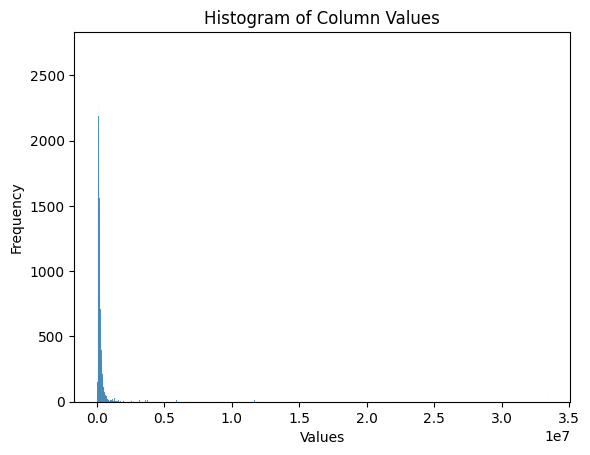

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert PySpark DataFrame column to a pandas Series
column_values = df.select('Price').rdd.flatMap(lambda x: x).collect()

# Create a histogram
sns.histplot(column_values)

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Column Values')

# Show the plot
plt.show()

In [ ]:
#getting rid of outliers
from pyspark.sql.functions import stddev, mean

# we Calculated the standard deviation and mean of the target column
stddev_price = df.select(stddev('Price')).first()[0]
mean_price = df.select(mean('Price')).first()[0]

# we Defined the threshold for outliers (3 standard deviations from the mean)
threshold = 3 * stddev_price

# Filtering out rows where the Price is beyond the threshold
outliers = df.filter((col('Price') <= mean_price - threshold) | (col('Price') >= mean_price + threshold))
# Show the outliers
outliers.show(5)



+----------+--------+-----------+--------+------------------+-------+------+-------------+----------+--------+------------------+----+------------------+
|  SaleDate|SaleType|      Price|PostCode|              City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|     price_per_sqm|year|     price_z_score|
+----------+--------+-----------+--------+------------------+-------+------+-------------+----------+--------+------------------+----+------------------+
|31/01/2019|    SALE|  5996088.0|   31100|          TOULOUSE|      3|     2|    APARTMENT|        51|       0|117570.35294117648|2019| 4.034573176072384|
|27/04/2017|    SALE|  9052959.0|   31400|          TOULOUSE|      3|     1|    APARTMENT|        68|       0|         133131.75|2017| 6.210770107211112|
|08/04/2015|    SALE|2.2388534E7|   31300|          TOULOUSE|      3|     1|    APARTMENT|        80|       0|        279856.675|2015|15.704411608592862|
|08/04/2015|    SALE|2.2388534E7|   31830|PLAISANCE DU TOUCH|      3|     0|



*   Key 2 : In here for example we see a list of very expensive apprtments with outstanding prices. Some of them have only 1 room which may raise an anomalie.



**3: Differences of prices per cities and postal codes**

In [ ]:
# Calculating average price per city
avg_price_per_city = df.groupBy("City").agg(avg("Price").alias("avg_price")).orderBy("avg_price", ascending=False)

# Calculating average price per postal code
avg_price_per_postal_code = df.groupBy("PostCode").agg(avg("Price").alias("avg_price")).orderBy("avg_price", ascending=False)

# Showing average price per city and postal code
avg_price_per_city.show()
avg_price_per_postal_code.show()


+--------------------+------------------+
|                City|         avg_price|
+--------------------+------------------+
|    VIEILLE TOULOUSE| 572626.3119266055|
|              PIBRAC| 429226.9713740458|
|          SAINT-JEAN|372889.47660818713|
|RAMONVILLE-SAINT-...| 367133.3374125874|
|            TOULOUSE| 349099.2343232193|
|  PLAISANCE DU TOUCH|  336083.599796334|
|          AUCAMVILLE| 320177.1670212766|
|             BLAGNAC| 309906.3947252747|
|       TOURNEFEUILLE| 309098.4980289093|
|              LABEGE| 306294.2148148148|
|               BALMA| 300512.6686701728|
|             CUGNAUX|296176.07743496675|
|  AUZEVILLE-TOLOSANE| 287950.9792746114|
| VILLENEUVE TOLOSANE|287706.37907375646|
|SAINT-ORENS-DE-GA...| 286315.7557392103|
|               MURET| 275834.7009063444|
|             L UNION|270097.68225419667|
|   QUINT-FONSEGRIVES| 262555.5038560411|
|          ESCALQUENS|255022.96996996997|
|        CORNEBARRIEU|250722.18062397372|
+--------------------+------------

In [ ]:

# Sort
avg_price_per_city_sorted = avg_price_per_city.orderBy("avg_price", ascending=False)
avg_price_per_postal_code_sorted = avg_price_per_postal_code.orderBy("avg_price", ascending=False)

# sorted
print("Average Price per City (Sorted):")
avg_price_per_city_sorted.show()

print("Average Price per Postal Code (Sorted):")
avg_price_per_postal_code_sorted.show()


Average Price per City (Sorted):
+--------------------+------------------+
|                City|         avg_price|
+--------------------+------------------+
|    VIEILLE TOULOUSE| 572626.3119266055|
|              PIBRAC| 429226.9713740458|
|          SAINT-JEAN|372889.47660818713|
|RAMONVILLE-SAINT-...| 367133.3374125874|
|            TOULOUSE| 349099.2343232193|
|  PLAISANCE DU TOUCH|  336083.599796334|
|          AUCAMVILLE| 320177.1670212766|
|             BLAGNAC| 309906.3947252747|
|       TOURNEFEUILLE| 309098.4980289093|
|              LABEGE| 306294.2148148148|
|               BALMA| 300512.6686701728|
|             CUGNAUX|296176.07743496675|
|  AUZEVILLE-TOLOSANE| 287950.9792746114|
| VILLENEUVE TOLOSANE|287706.37907375646|
|SAINT-ORENS-DE-GA...| 286315.7557392103|
|               MURET| 275834.7009063444|
|             L UNION|270097.68225419667|
|   QUINT-FONSEGRIVES| 262555.5038560411|
|          ESCALQUENS|255022.96996996997|
|        CORNEBARRIEU|250722.18062397372|
+



*   Key 3 : • Top 5 average price per city :
- SAINT-JEAN 863260.856744186 euros
- PIBRAC 836622.0687732341 euros
- TOULOUSE 634151.5455853839 euros
- CUGNAUX 579626.7678571428 euros
- OLD TOULOUSE 570051.5 euros
• Top 5 average price per postal code :
- 31100 906419.3391700228 euros
- 31400 894884.7611846251 euros
- 31820 836622.0687732341euros
- 31300 742743.371497439 euros
- 31240 605719.5278622087 euros.

Interpretation : Variances in average prices among cities and postal codes may be tied to urban
development initiatives, infrastructure projects, or shifts in population dynamics. For Saint-Jean
and Pibrac, high average prices could be linked to upscale developments, while Toulouse's high
average price may be influenced by its role as a central economic and cultural hub. Suburban
areas with lower average prices may offer opportunities for more affordable housing or represent
emerging markets for future development.



**4: Difference between Apartment and Houses**

In [ ]:
# Average price for apartments and houses
avg_price_by_type = df.groupBy("ResidenceType").agg(avg("Price").alias("avg_price"))

avg_price_by_type.show()


+-------------+------------------+
|ResidenceType|         avg_price|
+-------------+------------------+
|        HOUSE| 375692.8470254958|
|    APARTMENT|314238.52752962284|
+-------------+------------------+





*   Key 4 : The higher average price for apartments might be influenced by an increased
demand for urban living, lifestyle preferences, or a shortage of centrally located housing. The
lower average price for houses may be indicative of a more affordable housing market segment or
greater availability of suburban housing.



**5 : Property type distribution**

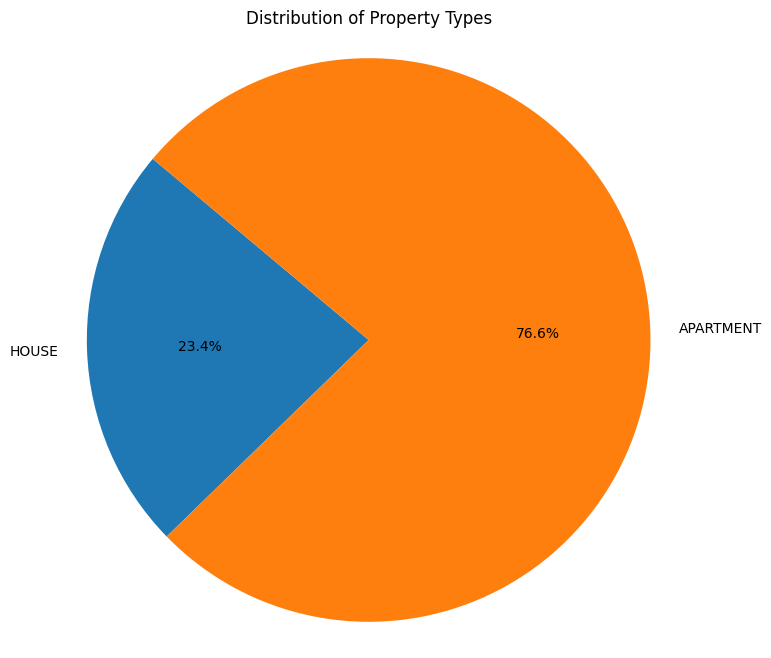

In [ ]:
# Count of each type of residence
residence_counts = df.groupBy("ResidenceType").count()

# Converting DataFrame to Pandas for visualization
residence_counts_pd = residence_counts.toPandas()

# Plot pie chart to visualize the distribution of property types
plt.figure(figsize=(8, 8))
plt.pie(residence_counts_pd["count"], labels=residence_counts_pd["ResidenceType"], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Property Types')
plt.axis('equal')
plt.show()


Key 5 : The dominance of apartments in the market aligns with contemporary urbanization
trends where individuals often prefer the convenience of living in or near city centers. This
distribution suggests that the company may find lucrative opportunities in developing or
marketing apartments to cater to the prevailing demand.

**6: Differences between toulouse and the suburbs**

Average Price for Toulouse: 349099.2343232193
Average Price for Suburbs: 288827.4118593135


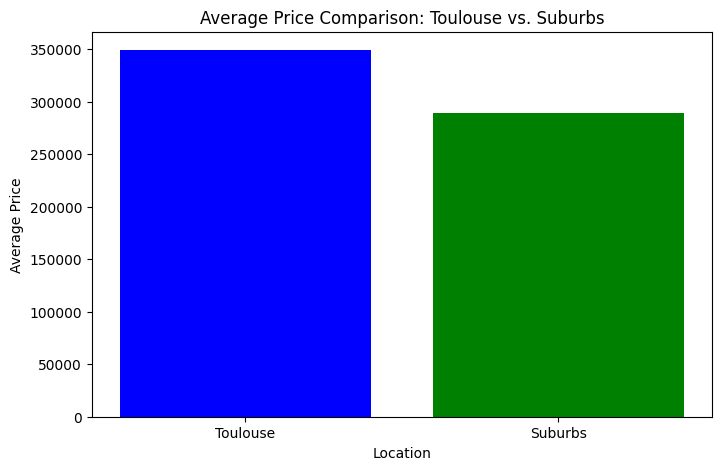

In [ ]:
# Calculating average price for Toulouse and its suburbs
avg_price_toulouse = df.filter(df["City"] == "TOULOUSE").agg(avg("Price")).collect()[0][0]
avg_price_suburbs = df.filter(df["City"] != "TOULOUSE").agg(avg("Price")).collect()[0][0]


#  printing to see why i dont get see toulouse
print("Average Price for Toulouse:", avg_price_toulouse)
print("Average Price for Suburbs:", avg_price_suburbs)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(["Toulouse", "Suburbs"], [avg_price_toulouse, avg_price_suburbs], color=['blue', 'green'])
plt.title('Average Price Comparison: Toulouse vs. Suburbs')
plt.xlabel('Location')
plt.ylabel('Average Price')
plt.show()


Key 6 : The substantial price difference between Toulouse and its suburbs may be linked
to the city's unique amenities, cultural attractions, and employment opportunities. Understanding
these disparities allows the company to tailor marketing and sales strategies to specific customer
segments, potentially capitalizing on both the central and suburban markets.

**7: Bonus**


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer




In [ ]:
# Drop rows with missing values
df_cleaned = df.dropna()
# Drop duplicates
df = df_cleaned.dropDuplicates()



In [ ]:
# Identify categorical columns
categorical_cols = [col for (col, dtype) in df_cleaned.dtypes if dtype == 'string']
# Identify numerical columns
numeric_columns = [col for (col, dtype) in df_cleaned.dtypes if dtype != 'string']



In [ ]:
#debugging
from pyspark.sql.functions import col
# Print schema
print("Schema before casting and filtering:")
df_cleaned.printSchema()

# Convert "Price" column to numeric type and filter out non-numeric values
df_filtered = df_cleaned.withColumn("Price", df_cleaned["Price"].cast("double")) \
                       .filter(col("Price").isNotNull())

# Print schema of the filtered DataFrame
print("Schema after casting and filtering:")
df_filtered.printSchema()

Schema before casting and filtering:
root
 |-- SaleDate: string (nullable = true)
 |-- SaleType: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- PostCode: string (nullable = true)
 |-- City: string (nullable = true)
 |-- NbRooms: integer (nullable = true)
 |-- NbLots: integer (nullable = true)
 |-- ResidenceType: string (nullable = true)
 |-- LivingArea: integer (nullable = true)
 |-- LandArea: integer (nullable = true)
 |-- price_per_sqm: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- price_z_score: double (nullable = true)

Schema after casting and filtering:
root
 |-- SaleDate: string (nullable = true)
 |-- SaleType: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- PostCode: string (nullable = true)
 |-- City: string (nullable = true)
 |-- NbRooms: integer (nullable = true)
 |-- NbLots: integer (nullable = true)
 |-- ResidenceType: string (nullable = true)
 |-- LivingArea: integer (nullable = true)
 |-- LandArea: integer (null

In [ ]:
# Verify Data Types
print("Data Types:")
df.printSchema()

# Inspect Data
print("\nSample Data:")
df.show(5)

# Check for unexpected values
print("\nSummary Statistics:")
df.describe().show()




Data Types:
root
 |-- SaleDate: string (nullable = true)
 |-- SaleType: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- PostCode: string (nullable = true)
 |-- City: string (nullable = true)
 |-- NbRooms: integer (nullable = true)
 |-- NbLots: integer (nullable = true)
 |-- ResidenceType: string (nullable = true)
 |-- LivingArea: integer (nullable = true)
 |-- LandArea: integer (nullable = true)
 |-- price_per_sqm: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- price_z_score: double (nullable = true)


Sample Data:
+----------+--------+--------+--------+-------------+-------+------+-------------+----------+--------+------------------+----+--------------------+
|  SaleDate|SaleType|   Price|PostCode|         City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|     price_per_sqm|year|       price_z_score|
+----------+--------+--------+--------+-------------+-------+------+-------------+----------+--------+------------------+----+------------------

**Linear Regression**

In [ ]:
from pyspark.sql.functions import col, to_date

# Converting SaleDate to DateType
df = df.withColumn("SaleDate", to_date(col("SaleDate"), "dd/MM/yyyy"))

# Droping rows with null values
df = df.dropna()
from pyspark.sql.functions import col

from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DoubleType

# Converting string columns to integer type
df = df.withColumn("NbRooms", col("NbRooms").cast(IntegerType()))
df = df.withColumn("NbLots", col("NbLots").cast(IntegerType()))
df = df.withColumn("LivingArea", col("LivingArea").cast(IntegerType()))
df = df.withColumn("LandArea", col("LandArea").cast(IntegerType()))
df = df.withColumn("Price", col("Price").cast(DoubleType()))

from pyspark.sql.functions import col

# Filtering out rows with null values in any of the specified columns
df = df.filter(col("NbRooms").isNotNull())
df = df.filter(col("NbLots").isNotNull())
df = df.filter(col("LivingArea").isNotNull())
df = df.filter(col("LandArea").isNotNull())

# Converting numeric columns to the correct data type
numeric_cols = ['NbRooms', 'NbLots', 'LivingArea', 'LandArea']
for col_name in numeric_cols:
    df = df.withColumn(col_name, col(col_name).cast('integer'))

# Training the model
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

assembler = VectorAssembler(inputCols=['NbRooms', 'NbLots'], outputCol='features')
lr = LinearRegression(featuresCol='features', labelCol='Price')

pipeline = Pipeline(stages=[assembler, lr])
#model = pipeline.fit(train_data)


In [ ]:
#debugging
from pyspark.sql.types import StringType

columns_to_check = ['NbRooms', 'NbLots', 'LivingArea', 'LandArea','Price']

# Function to check if a column contains string values
def is_string_column(column):
    return column.dataType == StringType()

# print unique string values if the column contains string data type
for col_name in columns_to_check:
    if is_string_column(df.schema[col_name]):
        unique_values = df.select(col(col_name)).distinct().rdd.map(lambda row: row[0]).collect()
        print(f"Unique string values in column {col_name}: {unique_values}")
    else:
        print(f"Column {col_name} does not contain string values.")


Column NbRooms does not contain string values.
Column NbLots does not contain string values.
Column LivingArea does not contain string values.
Column LandArea does not contain string values.
Column Price does not contain string values.


In [ ]:
(train_data, test_data) = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# 1. Train the model
model = pipeline.fit(train_data)



In [ ]:

# 2. Evaluating the model
predictions = model.transform(test_data)

In [ ]:

# 2. Evaluate the model's performance
from pyspark.ml.evaluation import RegressionEvaluator

#we selected RMSE
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Price", metricName="rmse")

# the evaluation metric
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data Linear Regression = {:.2f}".format(rmse))

Root Mean Squared Error (RMSE) on test data Linear Regression = 1455820.44


**Decision tree**

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol='features', labelCol='Price')

pipeline = Pipeline(stages=[assembler, dt])

model = pipeline.fit(train_data)

predictions_dt = model.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator


evaluator = RegressionEvaluator(labelCol='Price', predictionCol='prediction', metricName='rmse')

# Calculate RMSE
rmse = evaluator.evaluate(predictions_dt)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

# Calculate MAE
evaluator.setMetricName('mae')
mae = evaluator.evaluate(predictions_dt)
print("Mean Absolute Error (MAE) on test data =", mae)


Root Mean Squared Error (RMSE) on test data = 1447962.9782197708
Mean Absolute Error (MAE) on test data = 246172.7018061732


**Random Forest**

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col


assembler = VectorAssembler(inputCols=['NbRooms', 'NbLots', 'LivingArea', 'LandArea'], outputCol='features')


rf = RandomForestRegressor(featuresCol='features', labelCol='Price')


pipeline = Pipeline(stages=[assembler, rf])


rf_model = pipeline.fit(train_data)

rf_predictions = rf_model.transform(test_data)


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the Random Forest model on test data
evaluator_rf = RegressionEvaluator(labelCol='Price', predictionCol='prediction', metricName='rmse')
rmse_rf = evaluator_rf.evaluate(rf_predictions)

print("Root Mean Squared Error (RMSE) on test data (Random Forest) =", rmse_rf)


Root Mean Squared Error (RMSE) on test data (Random Forest) = 1420354.2346223572


**Gradient Boosted trees**

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

assembler = VectorAssembler(inputCols=['NbRooms', 'NbLots', 'LivingArea', 'LandArea'], outputCol='features')

gbt = GBTRegressor(featuresCol='features', labelCol='Price')

# Define the pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Train the Gradient Boosted Trees model
gbt_model = pipeline.fit(train_data)

# Make predictions on the test data
gbt_predictions = gbt_model.transform(test_data)


In [ ]:
# Evaluate the Gradient Boosted Trees model on test data
evaluator_gbt = RegressionEvaluator(labelCol='Price', predictionCol='prediction', metricName='rmse')
rmse_gbt = evaluator_gbt.evaluate(gbt_predictions)

print("Root Mean Squared Error (RMSE) on test data (Gradient Boosted Trees) =", rmse_gbt)


Root Mean Squared Error (RMSE) on test data (Gradient Boosted Trees) = 1419082.2992552496


**Observations**

These are the results we got ( we have tried different parameters, and different values of testing/training set) as we see above the RMSE is huge which mean that the differences between predicted and actual values are huge so we need to get rid of outliers

In [ ]:
#getting rid of outliers
from pyspark.sql.functions import stddev, mean

# we Calculated the standard deviation and mean of the target column
stddev_price = df.select(stddev('Price')).first()[0]
mean_price = df.select(mean('Price')).first()[0]

# we Defined the threshold for outliers (3 standard deviations from the mean)
threshold = 3 * stddev_price

# Filtering out rows where the Price is beyond the threshold
cleaned_df = df.filter((col('Price') >= mean_price - threshold) & (col('Price') <= mean_price + threshold))



In [ ]:
#testing with gradient boosting
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

assembler = VectorAssembler(inputCols=['NbRooms', 'NbLots', 'LivingArea', 'LandArea'], outputCol='features')

gbt = GBTRegressor(featuresCol='features', labelCol='Price')

pipeline = Pipeline(stages=[assembler, gbt])
(train_data1, test_data1) = cleaned_df.randomSplit([0.8, 0.2], seed=42)
gbt_model = pipeline.fit(train_data1)

gbt_predictions = gbt_model.transform(test_data1)


In [ ]:
# Evaluate the Gradient Boosted Trees model on test data
evaluator_gbt = RegressionEvaluator(labelCol='Price', predictionCol='prediction', metricName='rmse')
rmse_gbt = evaluator_gbt.evaluate(gbt_predictions)

print("Root Mean Squared Error (RMSE) on test data (Gradient Boosted Trees) =", rmse_gbt)


Root Mean Squared Error (RMSE) on test data (Gradient Boosted Trees) = 235585.49431924522


**Final Conclusion**

 We managed to reduce the RMSE to  235585.49431924522 which is good and it means that the our predictions are better.

  *NB : we tried all 4 algorithms again with the filtered out outliers sets and Gradient boosting was the best one so it was the one we chose to keep*